# Parameter Retrieval 3: Multi-temporal parameters

This example shows how to use the [rt1 python package](https://github.com/raphaelquast/rt1_model) together with [scipy optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) to setup a retrieval procedure to 

- obtain multiple dynamic parameters from a series of incidence-angle dependent $\sigma^0$ measurements.

> **NOTE:** to run this example you need the additional dependencies [matplotlib](https://matplotlib.org/) and [ipympl](https://matplotlib.org/ipympl/).


In [1]:
%matplotlib widget
from rt1_model import RT1, surface, volume, set_loglevel
from scipy.optimize import least_squares
import numpy as np

set_loglevel("info")

## Specify simulation and fit parameters
### Set parameter values that are used to simulate the data

In [2]:
dB, sig0 = False, True

num = 100  # Number of measurements
incs = 30  # Available incidence angles per measurement
noise_sigma = 0.5 if dB is True else 1e-3  # Noise-level (sigma of gaussian noise)

inc = np.random.normal(45, 10, (num, incs)).clip(20, 70)        # Incidence angles
N = np.random.normal(0.1, 0.1, (num, 1)).clip(0.01, 0.25)       # NormBRDF values
tau = (np.sin(np.linspace(0, 2*np.pi, num))**2)[:,np.newaxis]   # Optical Depth values

sim_params = dict(tau=tau, omega=0.2, N=N)  # Simulation parameter values
const_params = dict(t_s=0.4)                # Constant parameters (assumed to be known)

### Set start values and boundaries for the fit

In [3]:
start_vals = dict(omega=[0.2], tau=[0.3] * num, N=[0.1] * num)
bnd_vals = dict(omega=[(0.01, 0.5)], tau=[(0.01, 1.)] * num, N=[(0.01, 0.5)] * num)

## Setup RT1 and create a simulated dataset

In [4]:
V = volume.Rayleigh()
SRF = surface.HG_nadirnorm(t="t_s", ncoefs=10)

R = RT1(V=V, SRF=SRF, int_Q=True, dB=dB, sig0=sig0)
R.NormBRDF = "N"  # Use a synonym for NormBRDF parameter

R.set_geometry(t_0=np.deg2rad(inc), p_0=0, geometry="mono")
tot = R.calc(**sim_params, **const_params)[0]

# Add some random noise
tot += np.random.normal(0, noise_sigma, tot.shape)

12:54:21.382 INFO: Evaluating coefficients for interaction-term...


12:54:21.502 INFO: Coefficients extracted, it took 0.01341 sec.


D:\python_modules\RT1_new\src\rt1_model\_calc.py:1193: RuntimeWarning: invalid value encountered in add
  np.exp(-tau / mu) * np.log(mu / (1.0 - mu))


## Setup scipy optimize to fit RT1 model to the data

In [5]:
from scipy.sparse import csr_matrix, vstack, block_diag

def parse_params(x):
    """Map 1D parameter array to dict {parameter_name: value(s)}."""
    return dict(omega=x[0], tau=x[1:num+1][:, np.newaxis], N=x[num+1:][:, np.newaxis])

def fun(x):
    """Calculate residuals."""
    R.update_params(**parse_params(x), **const_params)
    res = R.calc()[0] - tot
    
    # Ravel output because scipy requires 1D arrays
    return res.ravel()

def jac(x):
    """Calculate jacobian."""
    R.update_params(**parse_params(x), **const_params)
    jac = R.jacobian(param_list=["omega", "tau", "N"])

    # Reshape jacobian to fit scipy.optimize requirements
    # (e.g. a 2D matrix of the shape (# measurements, # parameters) where each 
    # column represents the derivatives with respect to the optimized parameter)
    jac_columns = []
    # The first parameter (omega) is affected by all measurements, 
    # so the first row of the scipy-jacobian is given by the ravelled 
    # rt1-jacobian values.
    jac_columns += csr_matrix(jac[0].ravel())
    # The second and third parameters (tau, N) represent timeseries of
    # independent variables (e.g. one value for each timestamp). 
    # Therefore we need to convert the rt1-jacobian into a block-diagonal
    # matrix so that each parameter is only affected by the values 
    # of the corresponding timestamp.
    jac_columns += block_diag(jac[1].tolist(), "csr")
    jac_columns += block_diag(jac[2].tolist(), "csr")
        
    return vstack(jac_columns).T

# Unpack start-values and boundaries as required by scipy optimize
x0 = [*start_vals["omega"], *start_vals["tau"], *start_vals["N"]]
bounds = list(zip(*[*bnd_vals["omega"], *bnd_vals["tau"], *bnd_vals["N"]]))

res = least_squares(
    fun=fun,
    x0=x0,
    bounds=bounds,
    jac=jac,
    ftol=1e-5,
    gtol=1e-5,
    xtol=1e-5,
    verbose=2,
)

# Unpack found parameters
found_params = parse_params(res.x)
# Calcuate total backscatter based on found parameters
found_tot = R.calc(**found_params, **const_params)[0]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.1084e+00                                    1.49e+00    
       1              2         7.2653e-01      3.38e+00       1.32e+00       5.21e-01    
       2              3         2.6196e-01      4.65e-01       2.66e+00       2.14e+00    
       3              4         6.4990e-02      1.97e-01       8.95e-01       5.77e-01    


       4              5         4.7095e-02      1.79e-02       6.27e-01       6.07e-01    
       5              6         1.4328e-02      3.28e-02       4.45e-01       2.38e-01    
       6              7         1.3529e-02      8.00e-04       2.08e-03       2.05e-02    
       7              8         1.0287e-02      3.24e-03       4.18e-01       1.27e-01    


       8              9         9.2607e-03      1.03e-03       3.15e-03       9.76e-02    
       9             10         5.2969e-03      3.96e-03       1.31e-01       3.64e-02    
      10             11         5.0684e-03      2.28e-04       2.27e-03       7.63e-02    
      11             12         4.8264e-03      2.42e-04       2.50e-02       7.23e-02    


      12             13         4.7341e-03      9.23e-05       7.12e-04       1.29e-02    
      13             14         4.4746e-03      2.60e-04       2.44e-02       9.63e-03    
      14             15         4.2674e-03      2.07e-04       1.81e-02       9.80e-03    


      15             16         2.8041e-03      1.46e-03       1.80e-01       3.92e-02    
      16             17         2.4462e-03      3.58e-04       8.47e-02       2.34e-02    
      17             18         2.1429e-03      3.03e-04       5.11e-02       1.38e-02    
      18             19         1.9494e-03      1.94e-04       5.50e-02       1.08e-02    


      19             20         1.8344e-03      1.15e-04       4.19e-02       9.54e-03    
      20             21         1.7667e-03      6.77e-05       2.70e-02       6.55e-03    
      21             22         1.7283e-03      3.84e-05       1.98e-02       5.20e-03    
      22             23         1.7021e-03      2.62e-05       1.26e-02       3.21e-03    


      23             24         1.6881e-03      1.40e-05       7.58e-03       2.45e-03    
      24             25         1.6795e-03      8.58e-06       5.26e-03       2.24e-03    
      25             26         1.6744e-03      5.05e-06       4.16e-03       2.11e-03    


      26             27         1.6691e-03      5.33e-06       3.62e-03       1.95e-03    
      27             28         1.6616e-03      7.50e-06       3.27e-03       1.68e-03    
      28             29         1.6552e-03      6.41e-06       3.02e-03       1.39e-03    
      29             30         1.6510e-03      4.18e-06       1.99e-03       1.12e-03    


      30             31         1.6488e-03      2.23e-06       1.88e-03       9.35e-04    
      31             32         1.6474e-03      1.35e-06       2.62e-03       7.92e-04    
      32             33         1.6468e-03      5.95e-07       2.09e-03       6.99e-04    
      33             34         1.6466e-03      2.65e-07       1.27e-03       6.39e-04    


      34             35         1.6463e-03      2.76e-07       1.75e-03       5.68e-04    
      35             36         1.6460e-03      2.74e-07       1.97e-03       4.80e-04    
      36             37         1.6459e-03      1.60e-07       1.13e-03       4.24e-04    
      37             38         1.6457e-03      1.52e-07       1.20e-03       3.61e-04    
      38             39         1.6456e-03      1.09e-07       8.70e-04       3.00e-04    


      39             40         1.6455e-03      7.80e-08       8.28e-04       2.53e-04    
      40             41         1.6455e-03      5.10e-08       8.02e-04       2.17e-04    
      41             42         1.6455e-03      3.03e-08       5.98e-04       1.90e-04    
      42             43         1.6454e-03      2.63e-08       6.66e-04       1.70e-04    
      43             44         1.6454e-03      1.57e-08       4.57e-04       1.72e-04    
`ftol` termination condition is satisfied.
Function evaluations 44, initial cost 4.1084e+00, final cost 1.6454e-03, first-order optimality 1.72e-04.


## Visualize Results
### Plot timeseries

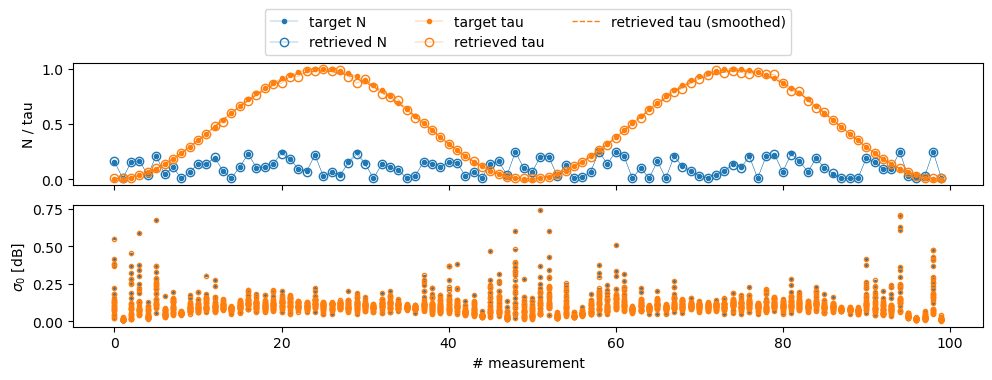

In [6]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

f, (ax, ax2) = plt.subplots(2, figsize=(10, 4), sharex=True)

# Plot retrieved parameter timeseries
ax.set_ylabel("N / tau")

ax.plot(sim_params["N"], marker=".", lw=0.25, label="target N", c="C0")
ax.plot(found_params["N"], marker="o", lw=0.25, markerfacecolor="none", label="retrieved N", c="C0")

ax.plot(sim_params["tau"], marker=".", lw=0.25, label="target tau", c="C1")
ax.plot(found_params["tau"], marker="o", lw=0.25, markerfacecolor="none", label="retrieved tau", c="C1")
ax.plot(savgol_filter(found_params["tau"].ravel(), 15, 3), lw=1, c="C1", ls="--", label="retrieved tau (smoothed)")

# Plot backscatter timeseries
ax2.set_ylabel(r"$\sigma_0$ [dB]")
ax2.set_xlabel("# measurement")

ax2.plot(tot, lw=0, marker=".", c="C0", ms=3)
ax2.plot(found_tot, lw=0, marker="o", markerfacecolor="none", c="C1", ms=3)

ax.legend(loc="upper center", ncols=3, bbox_to_anchor=(0.5, 1.5))
f.tight_layout()

### Initialize analyzer widget and overlay results

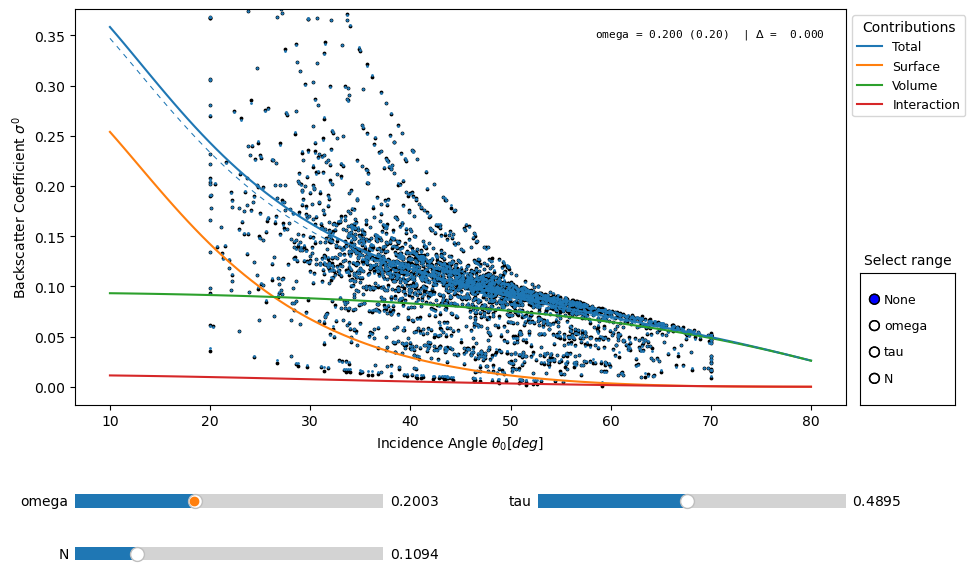

In [7]:
analyze_params = {key: (*np.mean(np.atleast_2d(bnd_vals[key]), axis=0), found_params[key].mean()) for key in found_params}

ana = R.analyze(param_dict=analyze_params)

# Plot fit-data on top
ana.ax.scatter(inc, tot, c="k", s=3, zorder=0)
ana.ax.scatter(inc, found_tot, c="C0", s=1, zorder=0)

# Indicate fit-results in slider-axes
for key, s in ana.sliders.items():
    if key in ["omega"]:
        s.ax.plot(sim_params[key], np.mean(s.ax.get_ylim()), marker="o")

# Add text for static parameters
t = ana.f.text(
    0.6,
    0.95,
    "\n".join(
        [
            f"{key:>8} = {found_params[key]:.3f} ({sim_params[key]:.2f})  "
            rf"| $\Delta$ = {found_params[key] - sim_params[key]: .3f}"
            for key in ["omega"]
        ]
    ),
    va="top",
    fontdict=dict(family="monospace", size=8),
)